In [1]:
from models import *
from priors_new import *
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.distributions import NegativeBinomial
import scanpy as sc

In [2]:
model_prior = GaussianMixturePrior(latent_dim=1, num_clusters=4)
model_encoder = build_encoder(dim_x=100, h_dim=64, n_layers=2)
#model_decoder = build_decoder_nb(dim_x=100, latent_dim=1, h_dim=64, n_layers=2, theta_mode="per_feature")
model_decoder = build_decoder_gaussian(dim_x=100, latent_dim=1, h_dim=64, n_layers=2)
#opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
model = EmpiricalBayesVariationalAutoencoder(encoder=model_encoder, enc_out_dim=64, decoder=model_decoder, prior=model_prior)

In [3]:
@torch.no_grad()
def generate_clustered_nb_1d(
    n_clusters: int = 4,
    points_per_cluster: int = 300,
    n_features: int = 100,
    latent_dim: int = 1,
    theta_val: float = 12.0,
    theta_per_feature: bool = False,
    theta_vec=None,                      # if None and theta_per_feature=True -> random vector
    theta_rand_sigma: float = 0.35,      # log-space std for random theta vector
    theta_clip: tuple[float, float] | None = (1e-3, 1e3),  # optional safety clip
    cluster_centers=None,
    cluster_spread: float = 0.2,
    seed: int = 42,
    device: str = "cpu",
):
    """
    If theta_per_feature == False:
        theta is scalar (theta_val), broadcast to [N, D].
    If theta_per_feature == True:
        theta is length-D:
            - use `theta_vec` if provided;
            - else sample random per-feature theta ~ LogNormal(log(theta_val), theta_rand_sigma^2).
    Returns:
        X [N,D], labels [N], z [N,latent_dim], centers [K,1], theta_f [D]
    """
    g = torch.Generator(device=device).manual_seed(seed)
    N = n_clusters * points_per_cluster

    # --- cluster centers ---
    if cluster_centers is None:
        centers = torch.linspace(-2, 2, n_clusters, device=device).unsqueeze(1)  # [K,1]
    else:
        centers = torch.tensor(cluster_centers, dtype=torch.float32, device=device).unsqueeze(1)

    # --- latents and labels ---
    labels = torch.arange(n_clusters, device=device).repeat_interleave(points_per_cluster)  # [N]
    z = torch.randn(N, latent_dim, generator=g, device=device) * cluster_spread
    z += centers[labels]

    # --- linear decoder for data gen ---
    W = torch.randn(n_features, latent_dim, generator=g, device=device) / math.sqrt(latent_dim)
    b = torch.randn(n_features, generator=g, device=device) * 0.2

    logits = z @ W.T + b                     # [N, D]
    px_scale = F.softmax(logits, dim=-1)     # [N, D]

    lib = torch.exp(torch.randn(N, 1, generator=g, device=device) * 0.25 + 8.5)
    # fixed library (you can replace with LogNormal if desired)
    #lib = 5000.0
    mu = lib * px_scale                      # [N, D]

    # --- theta construction ---
    if theta_per_feature:
        if theta_vec is not None:
            theta_f = torch.as_tensor(theta_vec, dtype=torch.float32, device=device)
            if theta_f.numel() != n_features:
                raise ValueError(f"`theta_vec` length {theta_f.numel()} != n_features {n_features}")
        else:
            # random per-feature theta ~ LogNormal(log(theta_val), theta_rand_sigma^2)
            log_mean = math.log(max(float(theta_val), 1e-12))
            theta_f = torch.exp(
                torch.randn(n_features, generator=g, device=device) * theta_rand_sigma + log_mean
            )
            if theta_clip is not None:
                lo, hi = theta_clip
                theta_f.clamp_(min=lo, max=hi)
        theta = theta_f.unsqueeze(0).expand(N, -1)  # [N, D]
    else:
        theta_f = torch.full((n_features,), float(theta_val), device=device)
        theta = torch.full_like(mu, float(theta_val))  # [N, D]

    # NB params and sampling
    p = theta / (theta + mu + 1e-8)
    nb = NegativeBinomial(total_count=theta, probs=p)
    X = nb.sample()  # [N, D], integer counts

    return X, labels.cpu(), z.cpu(), centers.cpu(), theta_f.cpu()

In [4]:
# Set up device and generate simulated data
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

#torch.manual_seed(42)

# Generate simulated dataset with 1D latent space
n_clusters = 4
points_per_cluster = 300
n_features = 100
latent_dim = 1

# Define cluster centers in 1D
cluster_centers = [-2.0, -0.75, 0.75, 2.0]  # Well-separated centers

X, y, Z_true, true_centers, theta_used = generate_clustered_nb_1d(
    n_clusters=n_clusters,
    points_per_cluster=points_per_cluster,
    n_features=n_features,
    latent_dim=latent_dim,
    theta_val=12.0,
    theta_per_feature=False,
    cluster_centers=cluster_centers,
    cluster_spread=0.2,  # Tight clusters
    seed=42,
    device=device
)

print(f"Generated dataset:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Z_true shape: {Z_true.shape}")
print(f"  True cluster centers: {true_centers.flatten().tolist()}")
print(f"  Number of clusters: {n_clusters}")
print(f"  Points per cluster: {points_per_cluster}")

Using device: cuda
Generated dataset:
  X shape: torch.Size([1200, 100])
  y shape: torch.Size([1200])
  Z_true shape: torch.Size([1200, 1])
  True cluster centers: [-2.0, -0.75, 0.75, 2.0]
  Number of clusters: 4
  Points per cluster: 300


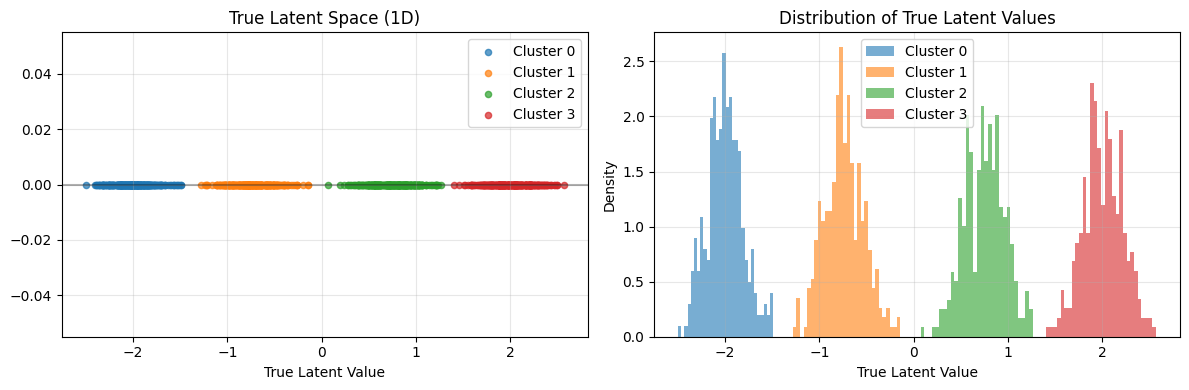

In [5]:
# Visualize the true latent space
plt.figure(figsize=(12, 4))

# Plot 1: True latent values colored by cluster
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(Z_true[mask, 0], np.zeros_like(Z_true[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('True Latent Value')
plt.ylabel('')
plt.title('True Latent Space (1D)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Histogram of true latent values by cluster
plt.subplot(1, 2, 2)
for i in range(n_clusters):
    mask = y == i
    plt.hist(Z_true[mask, 0], bins=30, alpha=0.6, label=f'Cluster {i}', density=True)
plt.xlabel('True Latent Value')
plt.ylabel('Density')
plt.title('Distribution of True Latent Values')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
def scanpy_norm_log1p_from_torch(X: torch.Tensor) -> torch.Tensor:
    # move to CPU + numpy (Scanpy expects numpy/scipy)
    X_np = X.detach().cpu().numpy().astype(np.float32, copy=False)

    adata = sc.AnnData(X_np)                 # create AnnData
    sc.pp.normalize_total(adata, target_sum=None, inplace=True)  # Scanpy normalize_total
    sc.pp.log1p(adata)                       # Scanpy log1p (natural log)

    # back to torch, preserve original device & dtype
    X_out = torch.from_numpy(adata.X).to(X.device).type_as(X)
    return X_out

In [7]:
X_norm = scanpy_norm_log1p_from_torch(X)

In [8]:
X_norm

tensor([[1.6204, 1.3965, 0.7000,  ..., 4.0608, 4.9298, 0.2259],
        [2.3453, 1.0287, 0.8536,  ..., 3.8369, 4.9079, 0.3711],
        [1.7505, 1.1212, 0.3462,  ..., 3.3133, 5.3604, 0.4828],
        ...,
        [0.8315, 1.5044, 2.4314,  ..., 0.3286, 0.1219, 3.9253],
        [1.5413, 1.4671, 2.2345,  ..., 0.5112, 0.0000, 4.3405],
        [1.4665, 2.1070, 2.6232,  ..., 0.9809, 0.4419, 3.9099]],
       device='cuda:0')

In [9]:
print(theta_used)
dl = DataLoader(TensorDataset(X_norm.float()), batch_size=128, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
model.to(device)

tensor([12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12.])


EmpiricalBayesVariationalAutoencoder(
  (prior): GaussianMixturePrior()
  (decoder): DiagGaussianDecoder(
    (backbone): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU(inplace=True)
    )
    (mu_head): Linear(in_features=64, out_features=100, bias=True)
    (logvar_head): Linear(in_features=64, out_features=100, bias=True)
  )
  (qz_head): DiagGaussianHead(
    (proj): Linear(in_features=64, out_features=2, bias=True)
  )
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=64, bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
)

In [10]:
model.train()
epochs, kl_warm = 400, 50
losses_history = []

print("Starting training...")
for ep in range(1, epochs+1):
    #kl_w = min(21.0, ep / kl_warm)
    kl_w = 1
    tot = 0.0; n = 0
    epoch_losses = {}
    
    for (xb,) in dl:
        xb = xb.to(device).float()
        outputs = model.train_step(xb, opt)
        losses={"loss":outputs["vae-loss"]}
        
        # Accumulate losses
        for key, value in losses.items():
            if key not in epoch_losses:
                epoch_losses[key] = 0.0
            epoch_losses[key] += value.item() * xb.size(0)
        
        tot += losses["loss"].item() * xb.size(0)
        n += xb.size(0)
    
    # Average losses
    for key in epoch_losses:
        epoch_losses[key] /= n
    losses_history.append(epoch_losses)
    
    if ep == 1 or ep % 2 == 0 or ep == epochs:
        #print(f"[{ep:03d}] loss={tot/n:.3f}  kl_w={kl_w:.2f}  recon={epoch_losses.get('recon', 0):.3f}  kl={epoch_losses.get('kl', 0):.3f}")
        print(f"[{ep:03d}] loss={tot/n:.3f}")

print("Training completed!")

Starting training...
[001] loss=12443.270
[002] loss=10979.054
[004] loss=6300.087
[006] loss=2041.940
[008] loss=501.161
[010] loss=195.875
[012] loss=155.924
[014] loss=129.547
[016] loss=115.910
[018] loss=108.136
[020] loss=105.559
[022] loss=106.233
[024] loss=99.718
[026] loss=97.635
[028] loss=97.907
[030] loss=92.172
[032] loss=95.364
[034] loss=87.959
[036] loss=86.240
[038] loss=86.737
[040] loss=92.240
[042] loss=83.381
[044] loss=87.067
[046] loss=84.681
[048] loss=79.021
[050] loss=77.452
[052] loss=79.172
[054] loss=77.115
[056] loss=70.180
[058] loss=73.585
[060] loss=72.383
[062] loss=67.775
[064] loss=67.061
[066] loss=66.524
[068] loss=66.443
[070] loss=66.048
[072] loss=66.475
[074] loss=65.181
[076] loss=66.830
[078] loss=66.746
[080] loss=65.392
[082] loss=64.972
[084] loss=64.458
[086] loss=65.849
[088] loss=64.595
[090] loss=65.196
[092] loss=66.584
[094] loss=66.404
[096] loss=64.332
[098] loss=65.666
[100] loss=66.812
[102] loss=63.979
[104] loss=66.031
[106] l

In [11]:
model.eval()
with torch.no_grad():
    mu_q = model._define_variational_family(X_norm.float().to(device)).mean

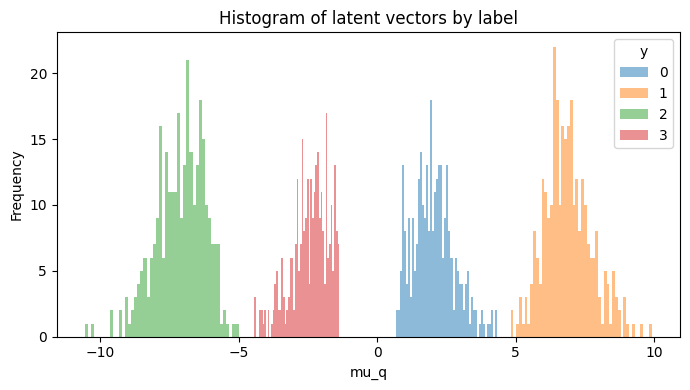

In [12]:
mu = mu_q.detach().flatten().to("cpu").numpy()
labels = y.detach().to("cpu").numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

# choose common bin edges so all histograms align
bins = np.histogram_bin_edges(mu, bins="auto")

# --- plot ---
plt.figure(figsize=(7,4))
for lab in np.unique(labels):
    sel = (labels == lab)
    plt.hist(mu[sel], bins=50, alpha=0.5, label=str(lab))  # counts (frequency)

plt.xlabel("mu_q")
plt.ylabel("Frequency")
plt.title("Histogram of latent vectors by label")
plt.legend(title="y")
plt.tight_layout()
plt.show()

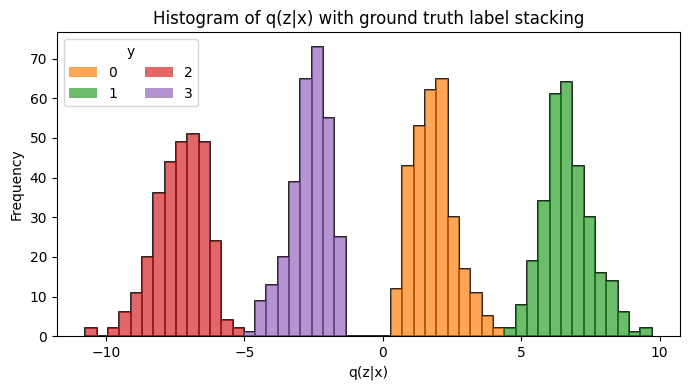

In [13]:
mu = mu_q.detach().flatten().cpu().numpy()
labels = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

# --- one common binning ---
bins = np.histogram_bin_edges(mu, bins=50)   # or "auto"
left  = bins[:-1]
width = np.diff(bins)

# overall histogram outline (no fill)
total_counts, _ = np.histogram(mu, bins=bins)
plt.figure(figsize=(7,4))
#plt.bar(left, total_counts, width=width, edgecolor='k', fill=False, linewidth=1.2, label='All')
plt.bar(left, total_counts, width=width, edgecolor='k', fill=False, linewidth=1.2)

# per-label stacked fill
bottom = np.zeros_like(total_counts, dtype=float)
for lab in np.unique(labels):
    sel = (labels == lab)
    counts, _ = np.histogram(mu[sel], bins=bins)
    plt.bar(left, counts, width=width, bottom=bottom, label=str(lab), alpha=0.7)
    bottom += counts

plt.xlabel("q(z|x)")
plt.ylabel("Frequency")
plt.title("Histogram of q(z|x) with ground truth label stacking")
plt.legend(title="y", ncol=2)
plt.tight_layout()
plt.show()

In [14]:
#mu_q = mu_q.unsqueeze(1)
resp = model.prior.log_prob_c_z(mu_q.unsqueeze(1))
print(model.prior.mu)

Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0159],
        [0.0000]], device='cuda:0', requires_grad=True)


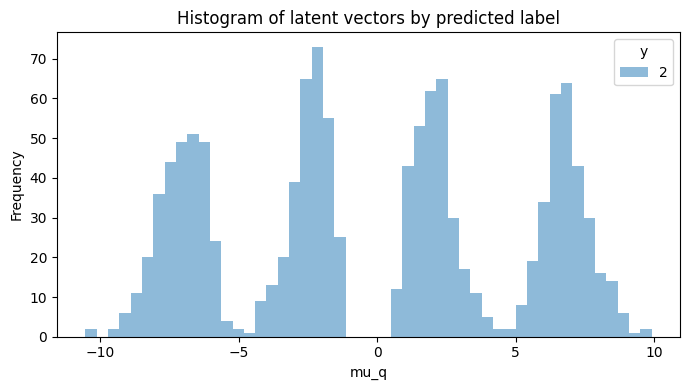

In [15]:
predict_label = resp.argmax(dim=1).detach().cpu().numpy()
bins = np.histogram_bin_edges(mu, bins="auto")

# --- plot ---
plt.figure(figsize=(7,4))
for lab in np.unique(predict_label):
    sel = (predict_label == lab)
    plt.hist(mu[sel], bins=50, alpha=0.5, label=str(lab))  # counts (frequency)

plt.xlabel("mu_q")
plt.ylabel("Frequency")
plt.title("Histogram of latent vectors by predicted label")
plt.legend(title="y")
plt.tight_layout()
plt.show()

In [16]:
from sklearn.mixture import GaussianMixture

Z_latent = mu.reshape(-1,1)
model_gmm = GaussianMixture(n_components=4, covariance_type="full", random_state=0).fit(Z_latent)

resp_gmm = model_gmm.predict_proba(Z_latent)
labels_gmm = model_gmm.predict(Z_latent)

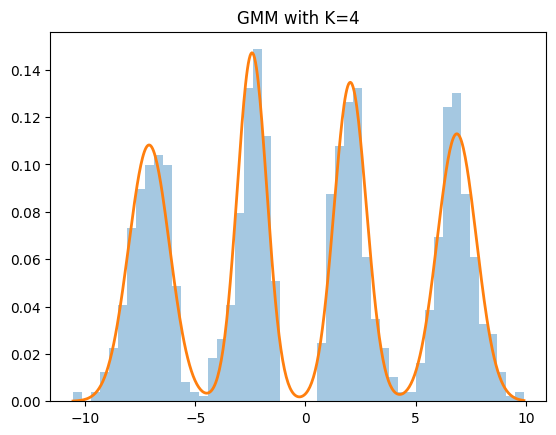

In [17]:
import matplotlib.pyplot as plt
xs = np.linspace(Z_latent.min(), Z_latent.max(), 500)[:, None]
logprob = model_gmm.score_samples(xs)                  # log p(x)
pdf = np.exp(logprob)

plt.figure()
plt.hist(Z_latent, bins=50, density=True, alpha=0.4)
plt.plot(xs, pdf, linewidth=2)
plt.title(f"GMM with K={model_gmm.n_components}")
plt.show()

In [18]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score(labels, labels_gmm, average_method="arithmetic")
ari = adjusted_rand_score(labels, labels_gmm)

print("NMI:", nmi)
print("ARI:", ari)

NMI: 0.9887438948017271
ARI: 0.9933352379153043


In [62]:
def plot_frequency(X: torch.Tensor, bins=50, title="Value frequency"):
    # Flatten to 1D and move to CPU/NumPy
    x = X.detach().reshape(-1).cpu().numpy()

    # Histogram of counts (frequency)
    plt.figure(figsize=(7,4))
    plt.hist(x, bins=bins, density=False)  # counts, not density
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.tight_layout()
    plt.show()

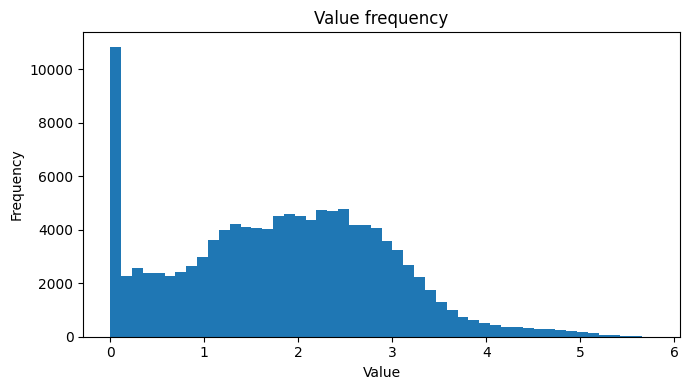

In [63]:
plot_frequency(X_norm)

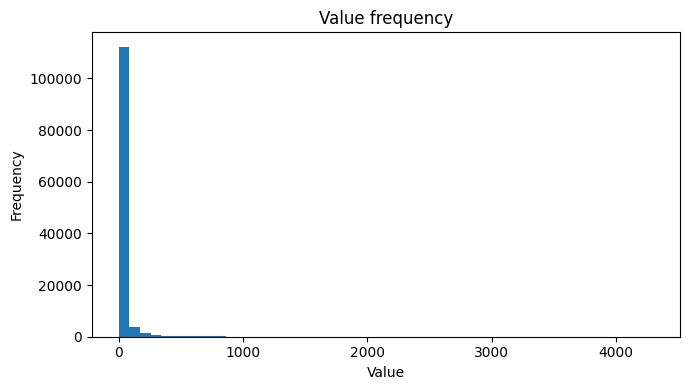

In [64]:
plot_frequency(X)